In [3]:
import json
api_token = {"username":"iobananaoi","key":"0cbdda23beeb18cbb57e9e88bf26bfd1"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [28]:
import cv2
import os
import matplotlib.pyplot as plt
import zipfile
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import kaggle
from functools import reduce

In [5]:
!kaggle datasets download -d romanleo2003/labtinkoff

100% 2.12G/2.13G [00:14<00:00, 165MB/s]
100% 2.13G/2.13G [00:14<00:00, 157MB/s]


In [9]:
zip_ref = zipfile.ZipFile("/content/labtinkoff.zip", 'r')
#zip_ref.extractall()

In [10]:
for name in zip_ref.namelist():  
    old_name = "/content/" + name
    new_name = name.encode("cp437").decode('utf-8')

    zip_ref.extract(name) 
    os.rename(name, new_name) 

In [127]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data processing

In [113]:
class CCPD(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_pathes = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
        self.img_labels = [label.split("-")[1][:-4] for label in self.img_pathes]
        self.img_dir = img_dir 
        self.transform = transform 

        self.unique_symbols = set([s for label in self.img_labels for s in label])
        self.symb2idx = {list(self.unique_symbols)[i]: i for i in range(len(self.unique_symbols))}
        self.idx2symb = {i: list(self.unique_symbols)[i] for i in range(len(self.unique_symbols))}
        
    def convert_label2idxs(self, label: str) -> list:
        return [self.symb2idx[symb] for symb in label]
    
    def convert_idxs2label(self, idxs: list) -> str:
        symbs_list = [self.idx2symb[idx.item()] for idx in idxs]
        return reduce(lambda x, y: x + y, symbs_list)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_pathes[idx])
        image = cv2.imread(img_path)
        image = cv2.resize(image, (100, 40))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        label = torch.tensor(self.convert_label2idxs(self.img_labels[idx]))
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [123]:
train_data = CCPD("/content/CCPD2019-dl1/train", transform=ToTensor())
#test = CCPD("/content/CCPD2019-dl1/test")

In [115]:
train_dataloader = DataLoader(train_data, batch_size=32)
#test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

Features shape: torch.Size([32, 1, 40, 100])
皖AN6360


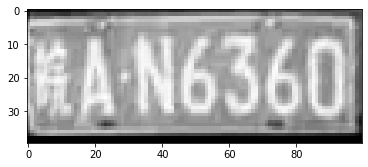

In [116]:
example_features, example_labels = next(iter(train_dataloader))
img = example_features[0].squeeze()
label = example_labels[0]
print(f"Features shape: {example_features.shape}")
print(train_data.convert_idxs2label(label))
plt.imshow(img, cmap="gray")
plt.show()

# Model structure

In [117]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(32),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=1)) 
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=1))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128*3589, latent_dims)
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

In [118]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, num_classes, num_layers=1, dropout=0.2):
        super(Decoder, self).__init__()

        self.lstm = nn.LSTM(latent_dims, latent_dims, num_layers, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(latent_dims*2, num_classes)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        out, state = self.lstm(x)
        logits = self.fc(out)
        preds = self.sm(logits)
        return preds

In [119]:
class CRNN(nn.Module):
    def __init__(self, latent_dims, num_classes, rnn_layers=2, rnn_dropout=0.05):
        super(CRNN, self).__init__()

        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims, num_classes, rnn_layers, rnn_dropout)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training part

In [132]:
batch_size = 32
num_classes = len(train_data.unique_symbols) + 1 # Reserve one more for blank symbol

In [133]:
def train(model, dataloader, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for i, (img, label) in enumerate(dataloader):
        img, label = img.to(device), label.to(device)

        # Pred computation
        pred = model(img)
        ctc_loss = nn.CTCLoss()
        input_lengths = torch.full(size=(batch_size,), fill_value=num_classes, dtype=torch.long)
        target_lengths = torch.full(size=(batch_size,), fill_value=num_classes, dtype=torch.long)
        loss = ctc_loss(pred, label, input_lengths, target_lengths)

        #Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            loss, current = loss.item(), i * len(img)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
model = CRNN(1000, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters())

train(model, train_dataloader, optimizer)